# LLM(Large Language Model) 使用示例

## 1 包导入

In [1]:
import lmitf
from lmitf import BaseLLM
from lmitf import TemplateLLM

## 2 QA示例
llm.call 方法接受几乎所有 OpenAI 的可选参数。默认使用 `gpt-4o` 模型，如需使用其他模型，可在调用时通过 `model` 参数指定。  
可选模型详见聚合 API 网站，这里以 [DMXAPI](https://www.dmxapi.cn/pricing) 为例。

### 2.1 单次问讯

In [2]:
llm = BaseLLM()
q = "Who is the president of the United States?"
llm.call(
    messages=[{'role': 'user', 'content': q}],
    response_format='text',
)
llm.print_history()


===================================== 👤 =====================================
Who is the president of the United States?

===================================== 🤖 =====================================
As of my last knowledge update in October 2023, the President of the United States is **Joe Biden**. He officially took office on January 20, 2021. If you're checking this at a later date, I recommend verifying with current sources to ensure accuracy.


### 2.2 多轮对话
基于示例化后的 `llm` 对象，在 `messages` 中添加多轮对话的历史记录。

In [3]:
q1 = "Where is the president from?"
res = llm.call(
    messages=llm.call_history + [{'role': 'user', 'content': q1}],
    response_format='text',
)
llm.print_history()


===================================== 👤 =====================================
Who is the president of the United States?

===================================== 🤖 =====================================
As of my last knowledge update in October 2023, the President of the United States is **Joe Biden**. He officially took office on January 20, 2021. If you're checking this at a later date, I recommend verifying with current sources to ensure accuracy.

===================================== 👤 =====================================
Where is the president from?

===================================== 🤖 =====================================
President **Joe Biden** is from **Scranton, Pennsylvania**. He was born there on **November 20, 1942**, and spent his early years in Scranton before his family moved to **Delaware** when he was 10 years old. Biden considers Delaware his home state, as he lived there for most of his life, launched his political career there, and represented Delaware in the U.

## 3 Embedding获取示例

embedding shape: (3072,)


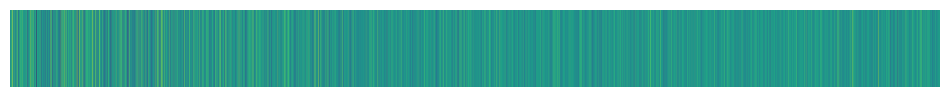

In [4]:
text = "hello world"
emed = llm.call_embed(
    input=text,
    model="text-embedding-3-large"
)

import numpy as np
import matplotlib.pyplot as plt
emed = np.array(emed)
print(f"embedding shape: {emed.shape}")
plt.figure(figsize=(12, 1))
plt.imshow(emed.reshape(1, -1), aspect='auto')
plt.axis('off')
plt.show()


## 4 模版化LLM调用
本节将演示如何自定义模版，并通过 `TemplateLLM` 进行调用。  
以下代码定义了一个 RDF 三元组抽取任务的 prompt模版
你也可以自己定义模版，遵循类似"[text2triples.py](https://github.com/colehank/AI-interface/blob/main/lmitf/datasets/llm_prompts/text2triples.py)" 的格式。

```python

In [5]:
template = lmitf.prompts.llm_prompts['text2triples'] # 数据库中的模板
template_llm = TemplateLLM(template) # 这里的template为一个.py文件路径，用户可以自己定义模版后传入TemplateLLM

Template loaded from
/Users/zgh/Desktop/workingdir/AI-interface/lmitf/datasets/llm_prompts/text2triples.py


In [6]:
lmitf.print_turn(template_llm.prompt_template)


===================================== ⚙️ =====================================
Your task is to construct an RDF (Resource Description Framework) graph from the given passages and named entity lists.
Respond with a JSON list of triples, with each triple representing a relationship in the RDF graph.

Pay attention to the following requirements:
- Each triple should contain at least one, but preferably two, of the named entities in the list for each passage.
- Clearly resolve pronouns to their specific names to maintain clarity.


===================================== 👤 =====================================

Convert the paragraph into a JSON dict,
it has a named entity list and a triple list.

Paragraph:
Radio City is India's first private FM radio station and was started on 3 July 2001.
It plays Hindi, English and regional songs.
Radio City recently forayed into New Media in May 2008 with the launch of a music portal - PlanetRadiocity.com that offers music related news, videos, songs, a

In [7]:
res = template_llm.call(
    passage="""
    Xiaoming, borned in Sichuan, 
    studies at Beijing Normal University, 
    belongs to its psychology department.
    """,
    named_entities=["Xiaoming", "Beijing", "Beijing Normal University", "psychology"],
    response_format='json',
    temperature=1.5,
)
res

{'triples': [['Xiaoming', 'born in', 'Sichuan'],
  ['Xiaoming', 'studies at', 'Beijing Normal University'],
  ['Beijing Normal University', 'located in', 'Beijing'],
  ['Xiaoming', 'belongs to', 'psychology department']]}

如上说明了该模版LLM需要在调用的时候提供`passage`, `named_entities`。对于自定义模版，仅需要在`conditioned_frame`用`$`表示需传入的参数即可，工具会自动解析

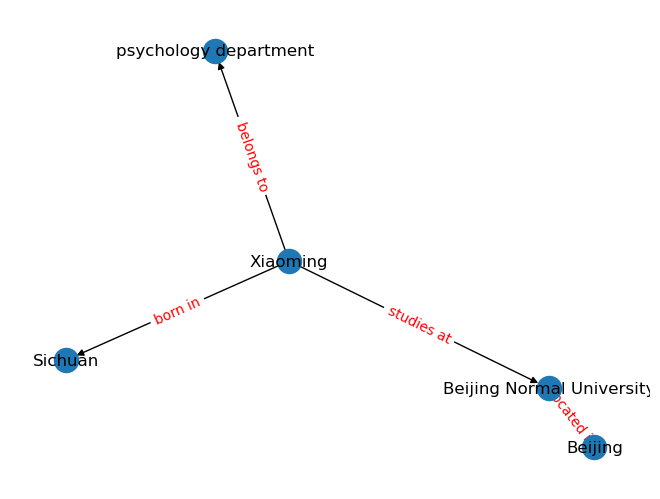

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
for head, relation, tail in res['triples']:
    G.add_edge(head, tail, label=relation)

pos = nx.spring_layout(G)
plt.figure()
nx.draw(G, pos, with_labels=True)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
plt.axis('off')
plt.show()